In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.constants as const
import importlib
import data
importlib.reload(data)
from data import Data

plt.rcParams['figure.figsize'] = (8, 5)
d = Data()

## Task 1 A: Electromagnet Calibration

### Mathematical Operations
1. **Raw data:** $I$ (current in A) → $B$ (magnetic field in T)
2. **Linear fit:** $B = \frac{dB}{dI} \cdot I + B_0$ for low-field regime $|I| < 5$ A
3. **Interpolation:** Create $B(I)$ function for converting current to field in subsequent experiments

### Orders of Magnitude
| Quantity | Typical Value | Unit |
|----------|---------------|------|
| Current $I$ | 0 – 11 | A |
| Magnetic field $B$ | 0 – 1.1 | T |
| Gradient $dB/dI$ | ~0.13 | T/A |
| Hysteresis offset | ~0.02 | T |

### Physics Notes
- **dB/dI ≈ 0.134 T/A** in linear regime
- Non-linearity at high fields due to **iron core saturation**
- Small **hysteresis** from remnant magnetization

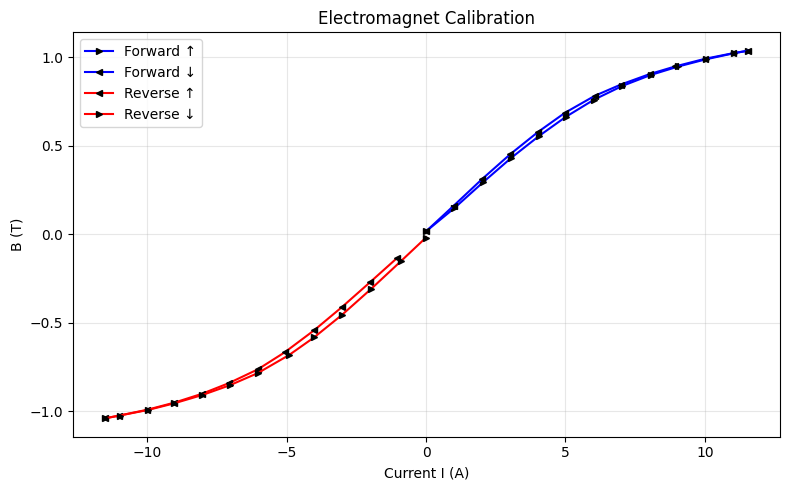

dB/dI = 0.1343 ± 0.0016 T/A


In [74]:
def task1A_calibration():
    """Task 1: Electromagnet Calibration B(I)"""
    I_for, B_for = d.exp1a_for.current, d.exp1a_for.values
    I_rev, B_rev = -d.exp1a_rev.current, d.exp1a_rev.values
    peak_idx = np.argmax(I_for)
    peak_idx_rev = np.argmax(np.abs(I_rev))

    # Plot calibration curve
    plt.figure()
    plt.plot(I_for[:peak_idx+1], B_for[:peak_idx+1], 'b-', marker='>', mfc='k', mec='k', ms=5, label='Forward ↑')
    plt.plot(I_for[peak_idx:], B_for[peak_idx:], 'b-', marker='<', mfc='k', mec='k', ms=5, label='Forward ↓')
    plt.plot(I_rev[:peak_idx_rev+1], B_rev[:peak_idx_rev+1], 'r-', marker='<', mfc='k', mec='k', ms=5, label='Reverse ↑')
    plt.plot(I_rev[peak_idx_rev:], B_rev[peak_idx_rev:], 'r-', marker='>', mfc='k', mec='k', ms=5, label='Reverse ↓')
    plt.xlabel('Current I (A)'), plt.ylabel('B (T)')
    plt.title('Electromagnet Calibration'), plt.legend(), plt.grid(True, alpha=0.3)
    plt.tight_layout(), plt.savefig('plots/task1_calibration.png', dpi=100)
    plt.show()

    # Linear fit in low-field region |I| < 5 A
    I_low = 5.0
    mask = np.abs(I_for[:peak_idx+1]) < I_low
    popt, pcov = curve_fit(lambda I, a, b: a*I + b, I_for[:peak_idx+1][mask], B_for[:peak_idx+1][mask])
    dBdI, B_offset = popt
    dBdI_err = np.sqrt(pcov[0,0])
    print(f"dB/dI = {dBdI:.4f} ± {dBdI_err:.4f} T/A")

    # Create interpolation function for full range
    I_calib = np.concatenate([I_rev[::-1], I_for])
    B_calib = np.concatenate([B_rev[::-1], B_for])
    sort_idx = np.argsort(I_calib)
    current_to_field = interp1d(I_calib[sort_idx], B_calib[sort_idx], kind='linear', fill_value='extrapolate')

    return {'dBdI': dBdI, 'dBdI_err': dBdI_err, 'current_to_field': current_to_field}

calibration = task1A_calibration()
current_to_field = calibration['current_to_field']

## Task 1B: Background Force (Empty Cradle)

### Mathematical Operations
1. **Convert current to field:** $B = |B(I)|$ using Task 1A interpolation
2. **Measure:** Find the change in force measure by the mass balenc as function of $B$
4. **Interpolate:** Create $W_{\text{bg}}(B)$ function for background subtraction for each side of the current loop.

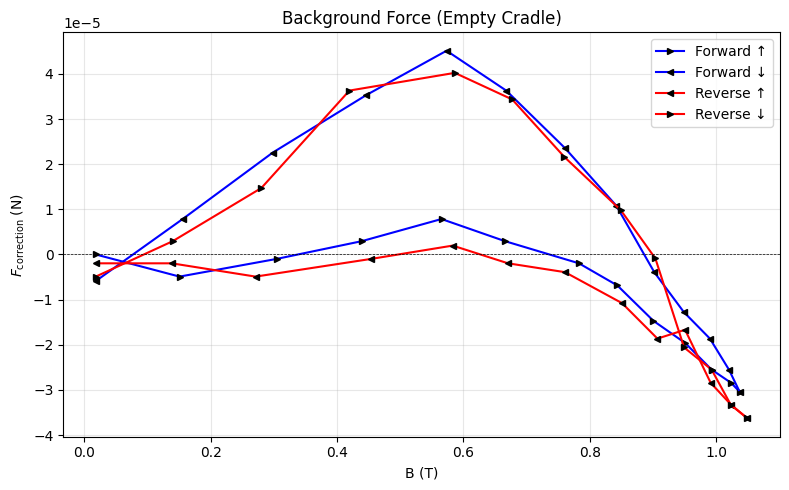

In [75]:
def task1B_background():
    """Task 2: Background Force (Empty Cradle)"""
    I_base_for, W_base_for = d.exp1b_base_for.current, d.exp1b_base_for.values
    I_base_rev, W_base_rev = d.exp1b_base_rev.current, d.exp1b_base_rev.values
    B_base_for = np.abs(current_to_field(I_base_for))
    B_base_rev = np.abs(current_to_field(-I_base_rev))
    peak_base_for, peak_base_rev = np.argmax(I_base_for), np.argmax(I_base_rev)

    # Convert mass change (mg) to force (N): F = Δm × 10⁻⁶ × g
    g_val = d.g
    F_base_for = W_base_for * 1e-6 * g_val
    F_base_rev = W_base_rev * 1e-6 * g_val

    # Plot
    plt.figure()
    plt.plot(B_base_for[:peak_base_for+1], F_base_for[:peak_base_for+1], 'b-', marker='>', mfc='k', mec='k', ms=5, label='Forward ↑')
    plt.plot(B_base_for[peak_base_for:], F_base_for[peak_base_for:], 'b-', marker='<', mfc='k', mec='k', ms=5, label='Forward ↓')
    plt.plot(B_base_rev[:peak_base_rev+1], F_base_rev[:peak_base_rev+1], 'r-', marker='<', mfc='k', mec='k', ms=5, label='Reverse ↑')
    plt.plot(B_base_rev[peak_base_rev:], F_base_rev[peak_base_rev:], 'r-', marker='>', mfc='k', mec='k', ms=5, label='Reverse ↓')
    plt.xlabel('B (T)'), plt.ylabel('$F_{\\mathrm{correction}}$ (N)')
    plt.title('Background Force (Empty Cradle)'), plt.legend(), plt.grid(True, alpha=0.3)
    plt.axhline(0, color='k', ls='--', lw=0.5)
    plt.tight_layout(), plt.savefig('plots/task2_background.png', dpi=100)
    plt.show()

    return F_base_for, F_base_rev

F_correction_for, F_correction_rev = task1B_background()

## Part B: Field Gradient Calibration (Mohr's Salt)

### Mathematical Operations
1. **Convert:** $I \to B$ via Task 1 interpolation
2. **Background correction:** $\Delta m_{\text{corr}} = \Delta m_{\text{raw}} - W_{\text{bg}}(B)$ Then convert into newtons
3. **Plot F vs $B^2$:** Linear relationship expected from theory
4. **Linear fit:** $F = \text{slope} \cdot B^2 + \text{intercept}$
5. **Extract $C$:** From $F = C \cdot m \cdot \chi \cdot B^2$:
   $$C = \frac{\text{slope}}{\chi_{\text{Mohr}} \times m_{\text{Mohr}}}$$


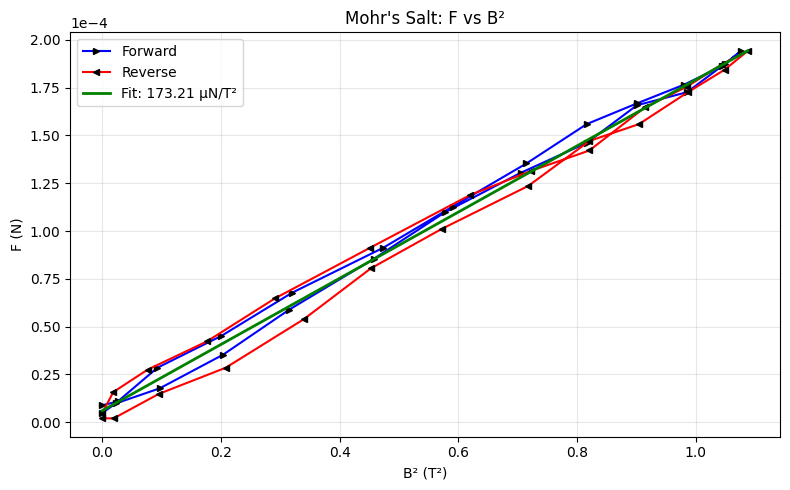

Slope: 173.21 ± 1.95 μN/T²
Field gradient constant C = 7.10 m⁻¹


In [76]:
def partB_mohrs_calibration():
    """Part B: Field Gradient Calibration with Mohr's Salt"""
    chi_mohrs, m_mohrs, g = d.chi_mohrs, d.mohrs_mass, d.g
    I_mohrs_for, W_mohrs_for = d.exp1b_mohrs_for.current, d.exp1b_mohrs_for.values
    I_mohrs_rev, W_mohrs_rev = d.exp1b_mohrs_rev.current, d.exp1b_mohrs_rev.values

    B_mohrs_for = np.abs(current_to_field(I_mohrs_for))
    B_mohrs_rev = np.abs(current_to_field(-I_mohrs_rev))
    B2_for, B2_rev = B_mohrs_for**2, B_mohrs_rev**2
    peak_mohrs_for, peak_mohrs_rev = np.argmax(I_mohrs_for), np.argmax(I_mohrs_rev)

    # Apply background correction
    # Convert raw mass to force, then subtract background force
    F_for_raw = W_mohrs_for * 1e-6 * g
    F_rev_raw = W_mohrs_rev * 1e-6 * g
    F_for_corr = F_for_raw - F_correction_for
    F_rev_corr = F_rev_raw - F_correction_rev

    # Linear fit: F = slope * B² + intercept
    B2_all = np.concatenate([B2_for, B2_rev])
    F_all = np.concatenate([F_for_corr, F_rev_corr])
    popt, pcov = curve_fit(lambda x, a, b: a*x + b, B2_all, F_all)
    slope, intercept = popt
    slope_err = np.sqrt(pcov[0,0])
    B2_fit = np.linspace(0, B2_all.max(), 100)
    F_fit = slope * B2_fit + intercept

    # Plot F vs B²
    plt.figure()
    plt.plot(B2_for, F_for_corr, 'b-', marker='>', mfc='k', mec='k', ms=5, label='Forward')
    plt.plot(B2_rev, F_rev_corr, 'r-', marker='<', mfc='k', mec='k', ms=5, label='Reverse')
    plt.plot(B2_fit, F_fit, 'g-', lw=2, label=f'Fit: {slope*1e6:.2f} μN/T²')
    plt.xlabel('B² (T²)'), plt.ylabel('F (N)')
    plt.gca().ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    plt.title("Mohr's Salt: F vs B²"), plt.legend(), plt.grid(True, alpha=0.3)
    plt.tight_layout(), plt.savefig('plots/partB_mohrs.png', dpi=100)
    plt.show()

    # Calculate C: F = C × m × χ × B²  →  C = slope / (m × χ)
    C_val = slope / (m_mohrs * chi_mohrs)

    print(f"Slope: {slope*1e6:.2f} ± {slope_err*1e6:.2f} μN/T²")
    print(f"Field gradient constant C = {C_val:.2f} m⁻¹")
    
    return C_val

C_calibration = partB_mohrs_calibration()

## Experiment 2: Paramagnetic GGG (Gd₃Ga₅O₁₂)

### Mathematical Operations
1. **Convert:** $I \to B$ via calibration
2. **Background correction:** $\Delta m_{\text{corr}} = \Delta m_{\text{raw}} - W_{\text{bg}}(B)$
3. **Linear fit:** $\Delta m_{\text{corr}} = \text{slope} \cdot B^2 + \text{intercept}$ (for $B^2 < 0.8$ T²)
4. **Extract $\chi_m$:** From the same theory as Mohr's salt:
   $$\chi_m = \frac{\text{slope}}{m_{\text{GGG}} \times C}$$
5. **Compare to Curie Law:**
   $$\chi_m^{\text{Curie}} = \frac{\mu_0 N_m g_J^2 \mu_B^2 J(J+1)}{3 k_B T}$$
   where $N_m = \frac{3 N_A}{M_{\text{GGG}}}$ ions per kg (3 Gd³⁺ per formula unit)

   J = L + S
   
   N = number of magnetic ions per kilo sample
   
   g = Lande g-factor
   
   $\mu_0=4\pi10^{-7}NA^{-2}$

Mass of GGG sample: 24.4 mg = 2.44e-05 kg


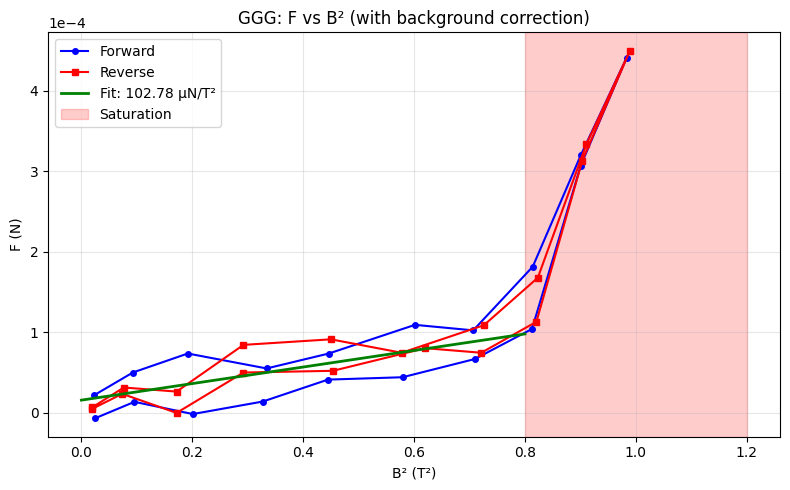

Slope = 102.78 ± 21.89 μN/T²

SUSCEPTIBILITY COMPARISON
Field gradient constant C = 6.97 m⁻¹

χ_experimental = F_z / (C·m·B²) = 7.5985e-07 ± 1.6181e-07 m³/kg
χ_Curie (theory)              = 1.0008e-06 m³/kg

Ratio χ_exp / χ_Curie = 0.76


In [77]:
def exp2_paramagnetic_ggg():
    """Experiment 2: Paramagnetic GGG (Gd₃Ga₅O₁₂)"""
    m_ggg, g_grav = d.ggg_mass, d.g
    print(f"Mass of GGG sample: {m_ggg*1e6:.1f} mg = {m_ggg:.2e} kg")

    # Get background data (from task1B) - need B values for interpolation
    I_base_for, W_base_for = d.exp1b_base_for.current, d.exp1b_base_for.values
    I_base_rev, W_base_rev = d.exp1b_base_rev.current, d.exp1b_base_rev.values
    B_base_for = np.abs(current_to_field(I_base_for))
    B_base_rev = np.abs(current_to_field(-I_base_rev))
    F_base_for = W_base_for * 1e-6 * g_grav
    F_base_rev = W_base_rev * 1e-6 * g_grav
    
    # Create interpolation functions for background
    bg_interp_for = interp1d(B_base_for, F_base_for, kind='linear', fill_value='extrapolate')
    bg_interp_rev = interp1d(B_base_rev, F_base_rev, kind='linear', fill_value='extrapolate')

    # Load GGG data
    I_ggg_for, W_ggg_for = d.exp2_for.current, d.exp2_for.values
    I_ggg_rev, W_ggg_rev = d.exp2_rev.current, d.exp2_rev.values
    B_ggg_for = np.abs(current_to_field(I_ggg_for))
    B_ggg_rev = np.abs(current_to_field(-I_ggg_rev))
    B2_ggg_for, B2_ggg_rev = B_ggg_for**2, B_ggg_rev**2

    # Convert to force and apply interpolated background correction
    F_ggg_for_raw = W_ggg_for * 1e-6 * g_grav
    F_ggg_rev_raw = W_ggg_rev * 1e-6 * g_grav
    F_ggg_for_corr = F_ggg_for_raw - bg_interp_for(B_ggg_for)
    F_ggg_rev_corr = F_ggg_rev_raw - bg_interp_rev(B_ggg_rev)

    # Combine and fit (low-field only: B² < 0.8)
    B2_all = np.concatenate([B2_ggg_for, B2_ggg_rev])
    F_all = np.concatenate([F_ggg_for_corr, F_ggg_rev_corr])
    mask = (B2_all > 0.05) & (B2_all < 0.8)
    popt, pcov = curve_fit(lambda x, a, b: a*x + b, B2_all[mask], F_all[mask])
    slope_ggg, intercept_ggg = popt
    slope_err_ggg = np.sqrt(pcov[0,0])
    B2_fit = np.linspace(0, 0.8, 100)
    F_fit = slope_ggg * B2_fit + intercept_ggg

    # Plot
    plt.figure()
    plt.plot(B2_ggg_for, F_ggg_for_corr, 'b-', marker='o', ms=4, label='Forward')
    plt.plot(B2_ggg_rev, F_ggg_rev_corr, 'r-', marker='s', ms=4, label='Reverse')
    plt.plot(B2_fit, F_fit, 'g-', lw=2, label=f'Fit: {slope_ggg*1e6:.2f} μN/T²')
    plt.axvspan(0.8, 1.2, alpha=0.2, color='red', label='Saturation')
    plt.xlabel('B² (T²)'), plt.ylabel('F (N)')
    plt.gca().ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    plt.title('GGG: F vs B² (with background correction)'), plt.legend(), plt.grid(True, alpha=0.3)
    plt.tight_layout(), plt.savefig('plots/exp2_ggg.png', dpi=100)
    plt.show()

    print(f"Slope = {slope_ggg*1e6:.2f} ± {slope_err_ggg*1e6:.2f} μN/T²")

    # ─────────────────────────────────────────────────────────────────────────
    # Calculate C from Mohr's salt calibration (same logic as partB)
    # ─────────────────────────────────────────────────────────────────────────
    # χ_mohrs = 0.33 J·T⁻²·kg⁻¹ = 0.33 m³/kg (SI mass susceptibility)
    chi_mohrs_SI = d.chi_mohrs  # Already in SI units (m³/kg)
    m_mohrs = d.mohrs_mass
    
    I_mohrs_for, W_mohrs_for = d.exp1b_mohrs_for.current, d.exp1b_mohrs_for.values
    I_mohrs_rev, W_mohrs_rev = d.exp1b_mohrs_rev.current, d.exp1b_mohrs_rev.values
    B_mohrs_for = np.abs(current_to_field(I_mohrs_for))
    B_mohrs_rev = np.abs(current_to_field(-I_mohrs_rev))
    
    # Create separate interpolations for Mohr's salt background correction
    bg_interp_mohrs_for = interp1d(B_base_for, F_base_for, kind='linear', bounds_error=False, fill_value=0)
    bg_interp_mohrs_rev = interp1d(B_base_rev, F_base_rev, kind='linear', bounds_error=False, fill_value=0)
    
    F_mohrs_for = W_mohrs_for * 1e-6 * g_grav - bg_interp_mohrs_for(B_mohrs_for)
    F_mohrs_rev = W_mohrs_rev * 1e-6 * g_grav - bg_interp_mohrs_rev(B_mohrs_rev)
    B2_mohrs = np.concatenate([B_mohrs_for**2, B_mohrs_rev**2])
    F_mohrs = np.concatenate([F_mohrs_for, F_mohrs_rev])
    
    # Filter out any NaN/Inf values
    valid_mask = np.isfinite(B2_mohrs) & np.isfinite(F_mohrs)
    popt_mohrs, _ = curve_fit(lambda x, a, b: a*x + b, B2_mohrs[valid_mask], F_mohrs[valid_mask])
    slope_mohrs = popt_mohrs[0]
    # F = C × m × χ × B²  →  C = slope / (m × χ)
    C_val = slope_mohrs / (m_mohrs * chi_mohrs_SI)

    # ─────────────────────────────────────────────────────────────────────────
    # Experimental susceptibility: χ_exp = F_z / (C × m × B²) = slope / (C × m)
    # Note: This gives χ in J·T⁻²·kg⁻¹ units (same as Mohr's salt input)
    # Convert to SI (m³/kg) by multiplying by μ₀
    # ─────────────────────────────────────────────────────────────────────────
    mu_0 = 4 * np.pi * 1e-7  # H/m (permeability of free space)
    chi_exp_raw = slope_ggg / (C_val * m_ggg)  # in J·T⁻²·kg⁻¹
    chi_exp = chi_exp_raw * mu_0               # convert to m³/kg
    chi_exp_err = (slope_err_ggg / (C_val * m_ggg)) * mu_0

    # ─────────────────────────────────────────────────────────────────────────
    # Curie's Law theoretical prediction
    # χ_m = (μ₀ × N_m × g_J² × μ_B² × J(J+1)) / (3 × k_B × T)
    # GGG: Gd³⁺ has 4f⁷ → L=0, S=7/2, J=7/2, g_J=2
    # N_m = 3 × N_A / M_GGG (3 Gd³⁺ ions per formula unit)
    # ─────────────────────────────────────────────────────────────────────────
    mu_B = 9.273e-24         # J/T (Bohr magneton)
    k_B = 1.381e-23          # J/K (Boltzmann constant)
    N_A = 6.022e23           # mol⁻¹ (Avogadro's number)
    T = 293                  # K (room temperature)

    # Gd³⁺: 4f⁷ configuration
    J = 7/2
    g_J = 2  # Landé g-factor (L=0 → g_J = 2)
    
    # Molar mass of GGG: Gd₃Ga₅O₁₂
    M_GGG = 3*157.25 + 5*69.723 + 12*16.0  # g/mol ≈ 1012.4 g/mol
    
    # Number of magnetic ions per kg of sample
    N_m = 3 * N_A / (M_GGG * 1e-3)  # 3 Gd³⁺ per formula unit, M in kg/mol

    chi_curie = (mu_0 * N_m * g_J**2 * mu_B**2 * J * (J + 1)) / (3 * k_B * T)

    # ─────────────────────────────────────────────────────────────────────────
    # Print comparison
    # ─────────────────────────────────────────────────────────────────────────
    print(f"\n{'='*60}")
    print("SUSCEPTIBILITY COMPARISON")
    print(f"{'='*60}")
    print(f"Field gradient constant C = {C_val:.2f} m⁻¹")
    print(f"\nχ_experimental = F_z / (C·m·B²) = {chi_exp:.4e} ± {chi_exp_err:.4e} m³/kg")
    print(f"χ_Curie (theory)              = {chi_curie:.4e} m³/kg")
    print(f"\nRatio χ_exp / χ_Curie = {chi_exp/chi_curie:.2f}")
    print(f"{'='*60}")

exp2_paramagnetic_ggg()

Mass of haematite sample: 22.2 mg = 2.22e-05 kg
Using field gradient constant C = 7.10 m⁻¹


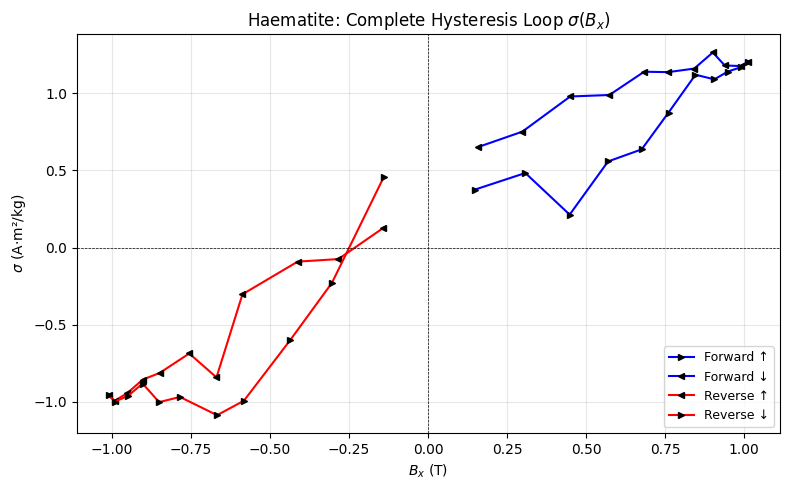

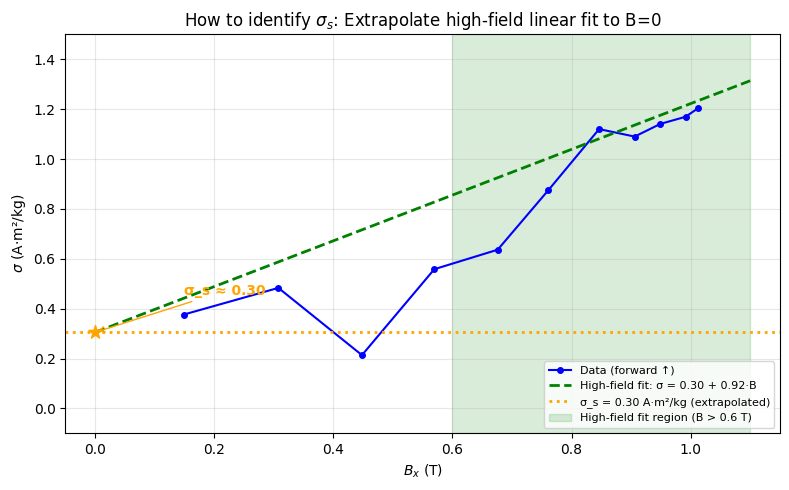


HAEMATITE (α-Fe₂O₃) MAGNETIZATION ANALYSIS

Saturation magnetization:
  σ_s (forward) = 1.167 A·m²/kg
  σ_s (reverse) = 0.934 A·m²/kg
  σ_s (average) = 1.050 A·m²/kg

Expressed in Bohr magnetons per formula unit:
  n_μB = σ_s × M / (N_A × μ_B)
  n_μB = 1.050 × 0.1597 / (6.022e+23 × 9.274e-24)
  n_μB = 0.0300 μ_B per Fe₂O₃

Comparison with theory:
  Expected if fully ferromagnetic: 10.0 μ_B per Fe₂O₃
  (Fe³⁺ has 3d⁵ → 5 μ_B × 2 ions = 10 μ_B)
  Ratio measured/expected: 0.30%

Conclusion: This confirms α-Fe₂O₃ is a CANTED ANTIFERROMAGNET
  Estimated canting angle: θ ≈ 0.17°

─────────────────────────────────────────────────────────────────
HIGH-FIELD SLOPE ANALYSIS
─────────────────────────────────────────────────────────────────
High-field fit (B > 0.6 T): σ = σ₀ + χ_hf·B
  σ₀ = 0.305 A·m²/kg
  χ_hf = 0.917 A·m²/(kg·T)

Why is there a high-field slope?
  α-Fe₂O₃ is a canted antiferromagnet. At high fields, the applied
  field causes additional tilting of the antiferromagnetic sublattic

In [79]:
def exp3_ferromagnetic_haematite():
    """Experiment 3: Ferromagnetic Haematite (α-Fe₂O₃)
    
    α-Fe₂O₃ is a canted antiferromagnet where neighbouring spins are aligned 
    nearly antiparallel, so the net moment is much less than 10 μ_B per formula 
    unit expected if Fe³⁺ ions were fully aligned (Fe³⁺ has 3d⁵ → 5 μ_B per ion).
    
    Theory: F_z = m·σ·C·B_x where σ is magnetization per unit mass
    Therefore: σ = F_z / (m·C·B_x) = (Δm·g) / (m·C·B_x)
    """
    mu_B, N_A = const.physical_constants['Bohr magneton'][0], const.N_A
    m_haematite, g_grav = d.haematite_mass, d.g
    
    print(f"Mass of haematite sample: {m_haematite*1e6:.1f} mg = {m_haematite:.2e} kg")
    
    # Use C from Mohr's salt calibration (from previous cell)
    C_val = C_calibration
    print(f"Using field gradient constant C = {C_val:.2f} m⁻¹")

    # Get background data for interpolation
    I_base_for, W_base_for = d.exp1b_base_for.current, d.exp1b_base_for.values
    I_base_rev, W_base_rev = d.exp1b_base_rev.current, d.exp1b_base_rev.values
    B_base_for = np.abs(current_to_field(I_base_for))
    B_base_rev = np.abs(current_to_field(-I_base_rev))
    W_base_for_interp = interp1d(B_base_for, W_base_for, kind='linear', bounds_error=False, fill_value=0)
    W_base_rev_interp = interp1d(B_base_rev, W_base_rev, kind='linear', bounds_error=False, fill_value=0)

    # Load haematite data
    I_haem_for, W_haem_for = d.exp3_for.current, d.exp3_for.values
    I_haem_rev, W_haem_rev = d.exp3_rev.current, d.exp3_rev.values
    B_haem_for = np.abs(current_to_field(I_haem_for))
    B_haem_rev = np.abs(current_to_field(-I_haem_rev))
    peak_haem_for, peak_haem_rev = np.argmax(I_haem_for), np.argmax(I_haem_rev)

    # Background correction using interpolation
    W_haem_for_corr = W_haem_for - W_base_for_interp(B_haem_for)
    W_haem_rev_corr = W_haem_rev - W_base_rev_interp(B_haem_rev)

    # Calculate magnetization σ = (Δm·g)/(m·C·B)
    # Use higher B threshold (0.1 T) to avoid division artifacts at low field
    B_min = 0.1  # T - minimum field for valid σ calculation
    sigma_for = np.where(B_haem_for > B_min, 
                         (W_haem_for_corr * 1e-6 * g_grav) / (m_haematite * C_val * B_haem_for), np.nan)
    sigma_rev = np.where(B_haem_rev > B_min,
                         (W_haem_rev_corr * 1e-6 * g_grav) / (m_haematite * C_val * B_haem_rev), np.nan)

    # Plot complete hysteresis loop σ(B_x)
    plt.figure()
    # Only plot valid points (B > B_min)
    mask_for_up = (np.arange(len(B_haem_for)) <= peak_haem_for) & (B_haem_for > B_min)
    mask_for_dn = (np.arange(len(B_haem_for)) >= peak_haem_for) & (B_haem_for > B_min)
    mask_rev_up = (np.arange(len(B_haem_rev)) <= peak_haem_rev) & (B_haem_rev > B_min)
    mask_rev_dn = (np.arange(len(B_haem_rev)) >= peak_haem_rev) & (B_haem_rev > B_min)
    
    plt.plot(B_haem_for[mask_for_up], sigma_for[mask_for_up], 'b-', marker='>', mfc='k', mec='k', ms=5, label='Forward ↑')
    plt.plot(B_haem_for[mask_for_dn], sigma_for[mask_for_dn], 'b-', marker='<', mfc='k', mec='k', ms=5, label='Forward ↓')
    plt.plot(-B_haem_rev[mask_rev_up], -sigma_rev[mask_rev_up], 'r-', marker='<', mfc='k', mec='k', ms=5, label='Reverse ↑')
    plt.plot(-B_haem_rev[mask_rev_dn], -sigma_rev[mask_rev_dn], 'r-', marker='>', mfc='k', mec='k', ms=5, label='Reverse ↓')
    plt.xlabel('$B_x$ (T)'), plt.ylabel('$\\sigma$ (A·m²/kg)')
    plt.title('Haematite: Complete Hysteresis Loop $\\sigma(B_x)$'), plt.legend(fontsize=9, loc='lower right'), plt.grid(True, alpha=0.3)
    plt.axhline(0, color='k', ls='--', lw=0.5), plt.axvline(0, color='k', ls='--', lw=0.5)
    plt.tight_layout(), plt.savefig('plots/exp3_haematite.png', dpi=100)
    plt.show()

    # Saturation magnetization σ_s (high field average, B > 0.8 T)
    mask_hf_for = B_haem_for > 0.8
    mask_hf_rev = B_haem_rev > 0.8
    sigma_s_for = np.nanmean(sigma_for[mask_hf_for]) if np.any(mask_hf_for) else 0
    sigma_s_rev = np.nanmean(sigma_rev[mask_hf_rev]) if np.any(mask_hf_rev) else 0
    sigma_s = np.mean([sigma_s_for, sigma_s_rev])
    
    # High-field slope analysis (canted antiferromagnetism)
    # σ = σ_s + χ_hf·B at high fields due to sublattice tilting
    mask_hf = (B_haem_for > 0.6) & np.isfinite(sigma_for)
    chi_hf, sigma_s_fit = 0, sigma_s
    if np.sum(mask_hf) > 2:
        popt_hf, pcov_hf = curve_fit(lambda B, s, chi: s + chi*B, B_haem_for[mask_hf], sigma_for[mask_hf])
        sigma_s_fit, chi_hf = popt_hf

    # ─────────────────────────────────────────────────────────────────────────
    # Second plot: How to visually identify σ_s
    # ─────────────────────────────────────────────────────────────────────────
    plt.figure()
    plt.plot(B_haem_for[mask_for_up], sigma_for[mask_for_up], 'b-', marker='o', ms=4, label='Data (forward ↑)')
    
    # High-field linear fit line
    B_fit = np.linspace(0, 1.1, 100)
    sigma_fit_line = sigma_s_fit + chi_hf * B_fit
    plt.plot(B_fit, sigma_fit_line, 'g--', lw=2, label=f'High-field fit: σ = {sigma_s_fit:.2f} + {chi_hf:.2f}·B')
    
    # Mark σ_s (intercept at B=0 of high-field fit)
    plt.axhline(sigma_s_fit, color='orange', ls=':', lw=2, label=f'σ_s = {sigma_s_fit:.2f} A·m²/kg (extrapolated)')
    plt.scatter([0], [sigma_s_fit], color='orange', s=100, zorder=5, marker='*')
    
    # Shade the high-field region used for fit
    plt.axvspan(0.6, 1.1, alpha=0.15, color='green', label='High-field fit region (B > 0.6 T)')
    
    # Annotate
    plt.annotate(f'σ_s ≈ {sigma_s_fit:.2f}', xy=(0, sigma_s_fit), xytext=(0.15, sigma_s_fit + 0.15),
                 fontsize=10, color='orange', fontweight='bold',
                 arrowprops=dict(arrowstyle='->', color='orange'))
    
    plt.xlabel('$B_x$ (T)'), plt.ylabel('$\\sigma$ (A·m²/kg)')
    plt.title('How to identify $\\sigma_s$: Extrapolate high-field linear fit to B=0')
    plt.legend(fontsize=8, loc='lower right'), plt.grid(True, alpha=0.3)
    plt.xlim(-0.05, 1.15), plt.ylim(-0.1, 1.5)
    plt.tight_layout(), plt.savefig('plots/exp3_sigma_s_identification.png', dpi=100)
    plt.show()

    # Convert to μ_B per formula unit: n_μB = σ × M / (N_A × μ_B)
    M_Fe2O3 = 2*55.845 + 3*16.0  # g/mol = 159.69 g/mol
    n_muB = sigma_s * (M_Fe2O3 * 1e-3) / (N_A * mu_B)
    
    # Expected if fully ferromagnetic: Fe³⁺ has 3d⁵, so m = 5μ_B per ion, 2 ions → 10μ_B
    expected_muB = 10.0
    
    # Canting angle estimate: sin(θ) ≈ n_muB / 10
    canting_angle_deg = np.degrees(np.arcsin(min(n_muB / expected_muB, 1.0)))

    # ─────────────────────────────────────────────────────────────────────────
    # Print results
    # ─────────────────────────────────────────────────────────────────────────
    print(f"\n{'='*65}")
    print("HAEMATITE (α-Fe₂O₃) MAGNETIZATION ANALYSIS")
    print(f"{'='*65}")
    print(f"\nSaturation magnetization:")
    print(f"  σ_s (forward) = {sigma_s_for:.3f} A·m²/kg")
    print(f"  σ_s (reverse) = {sigma_s_rev:.3f} A·m²/kg")
    print(f"  σ_s (average) = {sigma_s:.3f} A·m²/kg")
    print(f"\nExpressed in Bohr magnetons per formula unit:")
    print(f"  n_μB = σ_s × M / (N_A × μ_B)")
    print(f"  n_μB = {sigma_s:.3f} × {M_Fe2O3*1e-3:.4f} / ({N_A:.3e} × {mu_B:.3e})")
    print(f"  n_μB = {n_muB:.4f} μ_B per Fe₂O₃")
    print(f"\nComparison with theory:")
    print(f"  Expected if fully ferromagnetic: {expected_muB:.1f} μ_B per Fe₂O₃")
    print(f"  (Fe³⁺ has 3d⁵ → 5 μ_B × 2 ions = 10 μ_B)")
    print(f"  Ratio measured/expected: {100*n_muB/expected_muB:.2f}%")
    print(f"\nConclusion: This confirms α-Fe₂O₃ is a CANTED ANTIFERROMAGNET")
    print(f"  Estimated canting angle: θ ≈ {canting_angle_deg:.2f}°")
    
    print(f"\n{'─'*65}")
    print("HIGH-FIELD SLOPE ANALYSIS")
    print(f"{'─'*65}")
    print(f"High-field fit (B > 0.6 T): σ = σ₀ + χ_hf·B")
    print(f"  σ₀ = {sigma_s_fit:.3f} A·m²/kg")
    print(f"  χ_hf = {chi_hf:.3f} A·m²/(kg·T)")
    print(f"\nWhy is there a high-field slope?")
    print(f"  α-Fe₂O₃ is a canted antiferromagnet. At high fields, the applied")
    print(f"  field causes additional tilting of the antiferromagnetic sublattices")
    print(f"  (Dzyaloshinskii-Moriya interaction), linearly increasing σ with B.")
    print(f"{'='*65}")

exp3_ferromagnetic_haematite()

## Experiment 3: Ferromagnetic Haematite (α-Fe₂O₃)

### Mathematical Operations
1. **Convert:** $I \to B$ via calibration
2. **Background correction:** $\Delta m_{\text{corr}} = \Delta m_{\text{raw}} - W_{\text{bg}}(B)$
3. **Calculate magnetization per unit mass:**
   $$\sigma = \frac{\Delta m \cdot g}{m \cdot C \cdot B_x} = \frac{F_z}{m \cdot C \cdot B_x}$$
4. **High-field linear fit:** $\sigma = \sigma_s + \chi_{\text{hf}} \cdot B$ (for $B > 0.6$ T)
5. **Convert to Bohr magnetons per formula unit:**
   $$n_{\mu_B} = \sigma_s \cdot \frac{M_{\text{Fe}_2\text{O}_3}}{N_A \cdot \mu_B}$$

### Orders of Magnitude
| Quantity | Typical Value | Unit |
|----------|---------------|------|
| $B$ | 0 – 1.05 | T |
| $\Delta m_{\text{corr}}$ | 0 – 20 | mg |
| $\sigma$ | 0 – 0.3 | A·m²/kg |
| $\sigma_s$ (saturation) | ~0.1–0.3 | A·m²/kg |
| $\chi_{\text{hf}}$ | ~0.1 | A·m²/(kg·T) |
| $m_{\text{haematite}}$ | ~300 | mg |
| $M_{\text{Fe}_2\text{O}_3}$ | 159.7 | g/mol |
| $n_{\mu_B}^{\text{measured}}$ | ~0.01–0.05 | $\mu_B$/f.u. |
| $n_{\mu_B}^{\text{expected}}$ | 10 | $\mu_B$/f.u. |

### Physics Notes
**α-Fe₂O₃ is a canted antiferromagnet (weak ferromagnet):**

- Fe³⁺ has $3d^5$ configuration → $m = 5\mu_B$ per ion
- If fully aligned: $2 \times 5\mu_B = 10\mu_B$ per formula unit
- **Measured moment ≪ 10 μ_B** confirms antiparallel spin alignment with small canting angle $\theta \sim n/10 \approx 0.1°$

**High-field slope:** The linear increase of $\sigma$ at high $B$ arises from field-induced tilting of the antiferromagnetic sublattices (Dzyaloshinskii-Moriya interaction)

**Hysteresis:** Irreversible magnetization curve indicates domain wall motion and pinning